In [1]:
# import all necessary libraries
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
import copy

In [2]:
# Main foreground flows are energy use for loading, transport, and drying, including the material requirements 
# for concentrated solar drying technology, including associated infrastructure and equipment

# Independent Variables (Data Collection)
independent_variables = {
    # Sludge characteristics
    "initial_nitrogen_content": 0.015,  # kg N per kg wet sludge (1.5% as specified)
    "initial_moisture_content": 0.8,   # 80% moisture
    "total_solids_content": 0.2,       # 20% solids (= 1 - moisture content)
    "volatile_solids_fraction": 0.7,   # 70% of total solids are volatile
    
    # Anaerobic digestion parameters
    "nitrogen_retention_fraction": 0.9,  # After anaerobic digestion
    "organic_degradation_fraction": 0.4, # % of organic matter degraded
    
    # Drying parameters
    "nitrogen_loss_drying_fraction": 0.1,  # 10% nitrogen loss during drying
    
    # Transport parameters
    "distance_WWTP_to_drying": 50,     # km
    "distance_drying_to_farm": 100,    # km
    "transport_fuel_type": "diesel",   # Options: "diesel", "gasoline", "natural_gas", "electricity"
    "transport_nitrogen_loss_fraction": 0.0001,  # 1/100% loss in transport
    "truck_carrying_capacity": 25000,  # kg (25 metric tons)
    
    # Glass recycling parameters
    "glass_recycling_ratio": 0.9,      # 90% of glass can be recycled at end of life
    "glass_transport_distance": 100,   # km for transporting recycled glass
    
    # Fertilizer parameters
    "plant_available_nitrogen_fraction": 0.7,  # Fraction of total N available to plants
    
    # Drying parameters - to be selected based on technology
    "dryer_type": "csp_thermal",  # Concentrated Solar Power thermal drying
    
    # Target final moisture content after drying
    "target_moisture_content": 0.1,    # 10% moisture content after drying
    
    # Loading equipment parameters
    "loading_equipment_type": "front_loader",  # Options: "front_loader", "conveyor", "pump"
    "loading_energy_source": "diesel",  # Energy source for loading equipment
    
    # Facility parameters
    "facility_lifetime": 30,  # years
    "facility_capacity": 23000,  # tons of wet sludge per year (US tons)
    
    # Solar technology parameters
    "solar_technology_type": "csp_thermal",  # Concentrated solar power - direct thermal
    "solar_capacity_factor": 0.50,  # 50% average capacity factor
    "solar_system_lifetime": 20,  # years
    "csp_module_thermal_capacity": 1.0,  # MW thermal per module
    "latent_heat_vaporization": 2260,  # kJ/kg water

    # Diesel parameters
    "diesel_transport_consumption_per_km_ton": 0.30,
    "diesel_loading_energy_consumption_per_ton": 0.50
}

# Transport fuel specifications
transport_fuels = {
    "diesel": {
        "consumption_per_km_ton": 0.30,  # L/km·ton
        "unit": "L",
    },
    "gasoline": {
        "consumption_per_km_ton": 0.38,  # L/km·ton (less efficient than diesel)
        "unit": "L",
    },
    "natural_gas": {
        "consumption_per_km_ton": 0.35,  # kg/km·ton
        "unit": "kg",
    },
    "electricity": {
        "consumption_per_km_ton": 0.20,  # kWh/km·ton
        "unit": "kWh",
    }
}

# Loading equipment specifications
loading_equipment = {
    "front_loader": {
        "energy_source_options": ["diesel", "electricity"],
        "energy_consumption_per_ton": 0.5,  # L diesel per ton loaded
        "loading_rate": 60,  # tons per hour
        "equipment_lifetime": 10,  # years
        "equipment_weight": {
            "steel": 15000,  # kg
            "hydraulics": 1000,  # kg
            "electronics": 500  # kg
        }
    },
    "conveyor": {
        "energy_source_options": ["electricity"],
        "energy_consumption_per_ton": 0.3,  # kWh per ton loaded
        "loading_rate": 40,  # tons per hour
        "equipment_lifetime": 15,  # years
        "equipment_weight": {
            "steel": 8000,  # kg
            "rubber": 2000,  # kg
            "electronics": 300  # kg
        }
    },
    "pump": {
        "energy_source_options": ["electricity"],
        "energy_consumption_per_ton": 0.8,  # kWh per ton pumped
        "loading_rate": 80,  # tons per hour
        "equipment_lifetime": 8,  # years
        "equipment_weight": {
            "steel": 2000,  # kg
            "plastics": 500,  # kg
            "electronics": 200  # kg
        }
    }
}

# Facility construction specifications (per ton annual capacity)
facility_construction = {
    "concrete": 0.15,  # m³ per ton of annual capacity
    "reinforcing_steel": 15,  # kg per ton of annual capacity
    "structural_steel": 10,  # kg per ton of annual capacity
    "piping": 5,  # kg per ton of annual capacity
    "electrical": 2,  # kg per ton of annual capacity
    "insulation": 1,  # kg per ton of annual capacity
    "construction_energy": 300,  # MJ per ton of annual capacity
}

# Solar technology specifications (per module)
solar_technologies = {
    "csp_thermal": {  # Concentrated Solar Power - Direct Thermal
        "lifetime": 20,  # years
        "thermal_capacity_MW": 1.0,  # MW thermal per module
        "capacity_factor": 0.50,  # 50% capacity factor
        "materials_per_module": {
            # Based on provided data from screenshot
            "carbon_steel": 38708,  # kg (4584+4924+600+28600 from various components)
            "stainless_steel": 14168,  # kg (910+200+13058)
            "glass": 13521,  # kg (13058+463)
        },
        "annual_thermal_output_MWh": 4380,  # 4380 MWh thermal per year per module (1 MW * 8760 h * 0.5)
    }
}

In [3]:
# Functions for Dependent Variables    
def nitrogen_retained(initial_nitrogen, retention_fraction):
    """Calculate nitrogen retained after anaerobic digestion."""
    return initial_nitrogen * retention_fraction

def nitrogen_after_drying(nitrogen_content, loss_fraction):
    """Calculate nitrogen content after drying losses."""
    return nitrogen_content * (1 - loss_fraction)

def sludge_moisture_after_digestion(initial_moisture, degradation_fraction, volatile_solids_fraction):
    """Estimate moisture content after digestion, considering volatile solids reduction."""
    initial_solids = 1 - initial_moisture
    initial_volatile_solids = initial_solids * volatile_solids_fraction
    degraded_solids = initial_volatile_solids * degradation_fraction
    remaining_solids = initial_solids - degraded_solids
    return 1 - remaining_solids

def get_csp_thermal_requirements(moisture_before_drying, target_moisture, sludge_mass_tons, latent_heat_kJ_per_kg):
    """Calculate CSP thermal energy requirements for drying process."""
    # Convert tons to kg
    sludge_mass_kg = sludge_mass_tons * 907.185  # US tons to kg
    # Calculate water to be removed
    initial_water_content = sludge_mass_kg * moisture_before_drying
    final_solids = sludge_mass_kg * (1 - moisture_before_drying)
    final_total_mass = final_solids / (1 - target_moisture)
    final_water_content = final_total_mass - final_solids
    water_removed_kg = initial_water_content - final_water_content
    # Calculate thermal energy required (kJ)
    thermal_energy_kJ = water_removed_kg * latent_heat_kJ_per_kg
    thermal_energy_MWh = thermal_energy_kJ / 3600000  # Convert kJ to MWh
    return {
        "dryer_type": "csp_thermal",
        "energy_type": "solar_thermal",
        "final_moisture": target_moisture,
        "water_removed_kg": water_removed_kg,
        "thermal_energy_MWh": thermal_energy_MWh,
        "energy_unit": "MWh_thermal",}

def transport_energy(distance, fuel_type, load_mass=1.0, variables=None): # variables input added recently to fix sensitivity issue of diesel transport
    """Calculate transport energy based on fuel type."""
    if variables is not None: 
        fuel_consumption = variables["diesel_transport_consumption_per_km_ton"]
    else: 
        fuel_consumption = transport_fuels[fuel_type]["consumption_per_km_ton"] 
    return distance * fuel_consumption * load_mass

def nitrogen_after_transport(nitrogen_content, loss_fraction):
    """Calculate nitrogen content after transport losses."""
    return nitrogen_content * (1 - loss_fraction)

def plant_available_nitrogen(total_nitrogen, availability_fraction):
    """Calculate plant-available nitrogen in fertilizer."""
    return total_nitrogen * availability_fraction

def calculate_loading_requirements(equipment_type, energy_source, sludge_mass, variables=None): # variables input added recently to fix sensitivity issue of diesel loading
    """Calculate energy required for loading sludge onto vehicles."""
    equip_data = loading_equipment[equipment_type]  
    if energy_source not in equip_data["energy_source_options"]:
        energy_source = equip_data["energy_source_options"][0]
    if variables is not None: 
        energy_consumption = sludge_mass * variables["diesel_loading_energy_consumption_per_ton"]
    else:
        energy_consumption = sludge_mass * equip_data["energy_consumption_per_ton"]
    loading_time = sludge_mass / equip_data["loading_rate"]
    return {
        "equipment_type": equipment_type,
        "energy_source": energy_source,
        "energy_consumption": energy_consumption,
        "energy_unit": "L" if energy_source == "diesel" else "kWh",
        "loading_time": loading_time}

def compute_annual_thermal_output(thermal_capacity_MW, capacity_factor, variables=None): # variables input added recently to fix sensitivity issue of capacity factor and thermal capacity
    if variables is not None: 
        capacity_factor = variables["solar_capacity_factor"]
        thermal_capacity_MW = variables["csp_module_thermal_capacity"]
    return thermal_capacity_MW * 8760 * capacity_factor # 8760 hours per year

def calculate_csp_modules_required(thermal_energy_demand_MWh_per_year, system_lifetime, variables=None):
    """Calculate number of CSP modules required and their materials."""
    # Calculate total materials for 30-year system (modules manufactured twice since their lifetime is 20 years)
    materials_per_module = solar_technologies["csp_thermal"]["materials_per_module"]
    solar_module_lifetime = solar_technologies["csp_thermal"]["lifetime"]
    # Number of times modules need to be replaced over system lifetime
    module_sets_needed = math.ceil(system_lifetime / solar_module_lifetime)  # ceiling division
    total_materials = {}                                                                                          
    annual_output_per_module = compute_annual_thermal_output(
        solar_technologies["csp_thermal"]["thermal_capacity_MW"], 
        solar_technologies["csp_thermal"]["capacity_factor"],
        variables)
    modules_required = math.ceil(thermal_energy_demand_MWh_per_year / annual_output_per_module)*module_sets_needed
    for material, amount_per_module in materials_per_module.items():
        total_materials[f"csp_{material}"] = amount_per_module * modules_required
    # Calculate annual allocation over system lifetime
    annual_materials = {}
    for material, total_amount in total_materials.items():
        annual_materials[f"{material}_annual"] = total_amount / system_lifetime
    return {
        "modules_required": modules_required,
        "module_sets_needed": module_sets_needed,
        "total_materials": total_materials,
        "annual_materials": annual_materials}

def calculate_glass_recycling(glass_amount, recycling_ratio):
    """Calculate quantity of glass required considering recycling at end of life."""
    glass_recycled = glass_amount * recycling_ratio
    glass_required = glass_amount - glass_recycled
    return {
        "glass_recycled": glass_recycled,
        "glass_required": glass_required}

def calculate_facility_materials(facility_capacity, facility_lifetime):
    """Calculate materials required for facility construction."""
    results = {}
    for material, factor in facility_construction.items():
        if material != "construction_energy":
            results[f"facility_{material}"] = facility_capacity * factor
        else:
            results["facility_construction_energy"] = facility_capacity * factor
    
    for key, value in results.copy().items():
        results[f"{key}_annual"] = value / facility_lifetime
    return results

In [4]:
def calculate_sludge_to_fertilizer_impacts(variables):
    """
    Calculate the full impact chain for sludge-to-fertilizer conversion with CSP thermal drying.
    """
    results = {}
    
    # Step 1: Calculate nitrogen after digestion
    results["N_after_digestion"] = nitrogen_retained(
        variables["initial_nitrogen_content"],
        variables["nitrogen_retention_fraction"])
    
    # Step 2: Calculate moisture content after digestion
    results["moisture_after_digestion"] = sludge_moisture_after_digestion(
        variables["initial_moisture_content"],
        variables["organic_degradation_fraction"],
        variables["volatile_solids_fraction"])
    
    # Step 3: Calculate nitrogen after drying (with 10% loss)
    results["N_after_drying"] = nitrogen_after_drying(
        results["N_after_digestion"],
        variables["nitrogen_loss_drying_fraction"])
    
    # Step 4: Calculate CSP thermal requirements for annual capacity
    csp_thermal_results = get_csp_thermal_requirements(
        results["moisture_after_digestion"],
        variables["target_moisture_content"],
        variables["facility_capacity"],  # Annual capacity in tons
        variables["latent_heat_vaporization"])
    results.update(csp_thermal_results)
    
    # Step 5: Calculate CSP modules and materials required
    csp_materials = calculate_csp_modules_required(results["thermal_energy_MWh"], 
                                                   variables["facility_lifetime"],
                                                   variables)
    results["csp_materials"] = csp_materials
    
    # Step 6: Calculate mass of dried sludge
    initial_solids = 1 - variables["initial_moisture_content"]
    final_moisture = csp_thermal_results["final_moisture"]
    dried_sludge_mass = initial_solids / (1 - final_moisture)
    results["dried_sludge_mass"] = dried_sludge_mass
    
    # Step 7: Calculate loading requirements (per ton of wet sludge)
    results["loading_WWTP"] = calculate_loading_requirements(
        variables["loading_equipment_type"],
        variables["loading_energy_source"],
        1.0,
        variables)
    results["loading_drying"] = calculate_loading_requirements(
        variables["loading_equipment_type"],
        variables["loading_energy_source"],
        dried_sludge_mass,
        variables)
    total_loading_energy = results["loading_WWTP"]["energy_consumption"] + results["loading_drying"]["energy_consumption"]
    results["total_loading_energy"] = total_loading_energy
    results["loading_energy_unit"] = results["loading_WWTP"]["energy_unit"]
    
    # Step 8: Transport energy calculations
    results["transport_energy_WWTP_to_drying"] = transport_energy(
        variables["distance_WWTP_to_drying"],
        variables["transport_fuel_type"],
        1.0,
        variables) 
    results["transport_energy_drying_to_farm"] = transport_energy(
        variables["distance_drying_to_farm"],
        variables["transport_fuel_type"],
        dried_sludge_mass,
        variables) 
    # Calculate glass recycling and transport (occurs at end of each 20-year lifetime within system)
    total_glass_for_one_set = csp_materials["total_materials"]["csp_glass"] / csp_materials["module_sets_needed"]
    sets_recycled_within_system = variables["facility_lifetime"] // variables["solar_system_lifetime"]
    total_glass_recycled = total_glass_for_one_set * sets_recycled_within_system
    glass_recycling_results = calculate_glass_recycling(
        total_glass_recycled,
        variables["glass_recycling_ratio"])
    results["glass_recycling"] = glass_recycling_results
    results["sets_recycled_within_system"] = sets_recycled_within_system
    # Transport energy for recycled glass (amortized over 30-year system lifetime)
    results["transport_energy_glass_recycling"] = transport_energy(
        variables["glass_transport_distance"],
        variables["transport_fuel_type"],
        glass_recycling_results["glass_recycled"] / 1000,  # Convert kg to tons
        variables
    ) / variables["facility_lifetime"]  # Amortize over 30 years
    total_transport_fuel = (results["transport_energy_WWTP_to_drying"] + 
                           results["transport_energy_drying_to_farm"] + 
                           results["transport_energy_glass_recycling"])
    results["total_transport_fuel"] = total_transport_fuel
    results["transport_fuel_unit"] = transport_fuels[variables["transport_fuel_type"]]["unit"]
    
    # Step 9: Nitrogen content after transport
    results["N_after_transport"] = nitrogen_after_transport(
        results["N_after_drying"], 
        variables["transport_nitrogen_loss_fraction"])
    
    # Step 10: Plant-available nitrogen
    results["N_available"] = plant_available_nitrogen(
        results["N_after_transport"], 
        variables["plant_available_nitrogen_fraction"])
    
    # Step 11: Calculate facility construction materials
    facility_materials = calculate_facility_materials(
        variables["facility_capacity"],
        variables["facility_lifetime"])
    results["facility_materials"] = facility_materials
    
    # Step 12: Calculate total annual nitrogen output
    annual_nitrogen_kg = variables["facility_capacity"] * 907.185 * results["N_available"]  # Convert tons to kg
    results["annual_nitrogen_output_kg"] = annual_nitrogen_kg
    
    # Step 13: Calculate transport mass and distance totals accounting for truck trips
    # Calculate number of truck trips needed for annual capacity
    annual_wet_sludge_kg = variables["facility_capacity"] * 907.185  # Convert tons to kg
    annual_dried_sludge_kg = annual_wet_sludge_kg * dried_sludge_mass
    # Calculate trips needed for each transport stage
    trips_wwtp_to_drying = annual_wet_sludge_kg / variables["truck_carrying_capacity"]
    trips_drying_to_farm = annual_dried_sludge_kg / variables["truck_carrying_capacity"]
    trips_glass_recycling = (glass_recycling_results["glass_recycled"] / variables["truck_carrying_capacity"]) / variables["facility_lifetime"]  # Amortize over 30 years
    # Calculate total distances accounting for multiple trips
    total_distance_wwtp_to_drying = trips_wwtp_to_drying * variables["distance_WWTP_to_drying"]
    total_distance_drying_to_farm = trips_drying_to_farm * variables["distance_drying_to_farm"]
    total_distance_glass_recycling = trips_glass_recycling * variables["glass_transport_distance"]
    # Calculate total mass transported (accounting for the fact that each trip carries truck capacity)
    total_mass_transported = (annual_wet_sludge_kg + annual_dried_sludge_kg + (glass_recycling_results["glass_recycled"] / variables["facility_lifetime"])) / 1000  # Convert to tons
    total_km_traveled = total_distance_wwtp_to_drying + total_distance_drying_to_farm + total_distance_glass_recycling
    results["total_mass_transported"] = total_mass_transported
    results["total_km_traveled"] = total_km_traveled
    
    # Step 14: Calculate per functional unit (per kg N available)
    def calculate_functional_unit_foreground(annual_nitrogen_kg, thermal_energy_MWh, transport_fuel_amount, loading_energy, facility_materials, csp_materials, glass_recycling_results, total_mass_transported, total_km_traveled):
        """Calculate impacts per functional unit (kg N available)."""
        flows = {
            # Energy impacts
            "drying_thermal_energy_per_kg_N": thermal_energy_MWh * 1000 / annual_nitrogen_kg,  # kWh thermal per kg N
            "transport_fuel_per_kg_N": transport_fuel_amount / annual_nitrogen_kg,
            "loading_energy_per_kg_N": loading_energy / annual_nitrogen_kg,
            # Facility materials
            "facility_concrete_per_kg_N": facility_materials["facility_concrete_annual"] / annual_nitrogen_kg,
            "facility_reinforcing_steel_per_kg_N": facility_materials["facility_reinforcing_steel_annual"] / annual_nitrogen_kg,
            "facility_structural_steel_per_kg_N": facility_materials["facility_structural_steel_annual"] / annual_nitrogen_kg,
            "facility_piping_per_kg_N": facility_materials["facility_piping_annual"] / annual_nitrogen_kg,
            "facility_electrical_per_kg_N": facility_materials["facility_electrical_annual"] / annual_nitrogen_kg,
            "facility_insulation_per_kg_N": facility_materials["facility_insulation_annual"] / annual_nitrogen_kg,
            # CSP materials
            "csp_carbon_steel_per_kg_N": csp_materials["annual_materials"]["csp_carbon_steel_annual"] / annual_nitrogen_kg,
            "csp_stainless_steel_per_kg_N": csp_materials["annual_materials"]["csp_stainless_steel_annual"] / annual_nitrogen_kg,
            "csp_glass_per_kg_N": csp_materials["annual_materials"]["csp_glass_annual"] / annual_nitrogen_kg,
            "csp_glass_recycled_per_kg_N": (glass_recycling_results["glass_recycled"] / variables["facility_lifetime"]) / annual_nitrogen_kg,
            # Transport totals
            "total_mass_transported_per_kg_N": total_mass_transported / annual_nitrogen_kg,
            "total_km_traveled_per_kg_N": total_km_traveled / annual_nitrogen_kg,
        }
        return flows
    
    results["per_kg_N_available"] = calculate_functional_unit_foreground(
        annual_nitrogen_kg,
        results["thermal_energy_MWh"],
        total_transport_fuel * variables["facility_capacity"],  # Scale to annual capacity
        total_loading_energy * variables["facility_capacity"],  # Scale to annual capacity
        facility_materials,
        csp_materials,
        glass_recycling_results,
        total_mass_transported,  # This is already in total for annual capacity
        total_km_traveled  # This is already in total for annual capacity
    )
    
    return results

In [5]:
# Run the model with the defined independent variables 
# annual average per kg N foreground inventory output
results = calculate_sludge_to_fertilizer_impacts(independent_variables)

# Print summary of key foreground flows per kg N
print("\n--- KEY FOREGROUND FLOWS PER KG N ---")
print(f"Available nitrogen in fertilizer: 1.00 kg N (functional unit)")
print(f"Annual wet sludge input: {independent_variables['facility_capacity'] * 907.185:.0f} kg")
print(f"Annual nitrogen output: {results['annual_nitrogen_output_kg']:.0f} kg N")
print(f"CSP modules required: {results['csp_materials']['modules_required']:.1f}")

# Energy flows
print("\n--- ENERGY FLOWS ---")
print(f"Drying thermal energy: {results['per_kg_N_available']['drying_thermal_energy_per_kg_N']:.2f} kWh_thermal")
print(f"Transport fuel: {results['per_kg_N_available']['transport_fuel_per_kg_N']:.2f} {results['transport_fuel_unit']}")
print(f"Loading energy: {results['per_kg_N_available']['loading_energy_per_kg_N']:.2f} {results['loading_energy_unit']}")

# Infrastructure materials
print("\n--- FACILITY INFRASTRUCTURE MATERIALS ---")
print(f"Concrete: {results['per_kg_N_available']['facility_concrete_per_kg_N']:.5f} m³")
print(f"Reinforcing steel: {results['per_kg_N_available']['facility_reinforcing_steel_per_kg_N']:.5f} kg")
print(f"Structural steel: {results['per_kg_N_available']['facility_structural_steel_per_kg_N']:.5f} kg")
print(f"Piping: {results['per_kg_N_available']['facility_piping_per_kg_N']:.5f} kg")
print(f"Electrical: {results['per_kg_N_available']['facility_electrical_per_kg_N']:.5f} kg")
print(f"Insulation: {results['per_kg_N_available']['facility_insulation_per_kg_N']:.5f} kg")

# CSP technology materials
print("\n--- CSP SOLAR TECHNOLOGY MATERIALS ---")
print(f"Carbon Steel: {results['per_kg_N_available']['csp_carbon_steel_per_kg_N']:.5f} kg")
print(f"Stainless Steel: {results['per_kg_N_available']['csp_stainless_steel_per_kg_N']:.5f} kg")
print(f"Glass: {results['per_kg_N_available']['csp_glass_per_kg_N']:.5f} kg")
print(f"Glass Recycled: {results['per_kg_N_available']['csp_glass_recycled_per_kg_N']:.5f} kg")

# Transport totals
print("\n--- TRANSPORT TOTALS ---")
print(f"Total mass transported: {results['per_kg_N_available']['total_mass_transported_per_kg_N']:.5f} tons")
print(f"Total kilometers traveled: {results['per_kg_N_available']['total_km_traveled_per_kg_N']:.2f} km")

print("\n--- VALIDATION CALCULATIONS ---")
print(f"Total thermal energy required annually: {results['thermal_energy_MWh']:.1f} MWh")
print(f"Water removed annually: {results['water_removed_kg']:.0f} kg")
print(f"Total glass for CSP modules: {results['csp_materials']['total_materials']['csp_glass']:.0f} kg")
print(f"CSP Module sets recycled within {independent_variables['facility_lifetime']} years: {results['sets_recycled_within_system']}")
print(f"Glass recycled from {results['sets_recycled_within_system']} set(s) ({independent_variables['glass_recycling_ratio']*100:.0f}%): {results['glass_recycling']['glass_recycled']:.0f} kg")


--- KEY FOREGROUND FLOWS PER KG N ---
Available nitrogen in fertilizer: 1.00 kg N (functional unit)
Annual wet sludge input: 20865255 kg
Annual nitrogen output: 177441 kg N
CSP modules required: 6.0

--- ENERGY FLOWS ---
Drying thermal energy: 62.01 kWh_thermal
Transport fuel: 7.54 L
Loading energy: 0.08 L

--- FACILITY INFRASTRUCTURE MATERIALS ---
Concrete: 0.00065 m³
Reinforcing steel: 0.06481 kg
Structural steel: 0.04321 kg
Piping: 0.02160 kg
Electrical: 0.00864 kg
Insulation: 0.00432 kg

--- CSP SOLAR TECHNOLOGY MATERIALS ---
Carbon Steel: 0.04363 kg
Stainless Steel: 0.01597 kg
Glass: 0.01524 kg
Glass Recycled: 0.00686 kg

--- TRANSPORT TOTALS ---
Total mass transported: 0.14373 tons
Total kilometers traveled: 0.34 km

--- VALIDATION CALCULATIONS ---
Total thermal energy required annually: 11002.9 MWh
Water removed annually: 17526814 kg
Total glass for CSP modules: 81126 kg
CSP Module sets recycled within 30 years: 1
Glass recycled from 1 set(s) (90%): 36507 kg


In [6]:
def calculate_time_discretized_inventory(variables):
    """
    Calculate time-discretized foreground inventory for each year from 2020 to 2050.
    Returns flows that occur in each specific year rather than annual averages divided by yearly N delivered.
    """
    # First get the basic system results
    basic_results = calculate_sludge_to_fertilizer_impacts(variables)
    
    # Initialize yearly inventory dictionary
    start_year = 2020
    end_year = 2050
    yearly_inventory = {}
    
    # Define flow categories
    annual_flows = ["wet_sludge_processed_kg", "dried_sludge_produced_kg", "nitrogen_delivered_kg", 
                   "drying_thermal_energy_MWh", "transport_fuel_WWTP_to_drying", "transport_fuel_drying_to_farm", 
                   "transport_fuel_glass_recycling", "loading_energy", "total_mass_transported_kg", "total_km_traveled"]
    infrastructure_flows = ["facility_concrete_m3", "facility_reinforcing_steel_kg", "facility_structural_steel_kg", 
                           "facility_piping_kg", "facility_electrical_kg", "facility_insulation_kg"]
    csp_flows = ["csp_carbon_steel_kg", "csp_stainless_steel_kg", "csp_glass_kg"]
    recycling_flows = ["glass_recycled_kg"]
    all_flows = annual_flows + infrastructure_flows + csp_flows + recycling_flows
    
    # Initialize all years with zero flows
    for year in range(start_year, end_year + 1):
        yearly_inventory[year] = {flow: 0 for flow in all_flows}
    
    # Calculate basic quantities
    annual_wet_sludge_kg = variables["facility_capacity"] * 907.185
    annual_dried_sludge_kg = annual_wet_sludge_kg * basic_results["dried_sludge_mass"]
    annual_nitrogen_kg = basic_results["annual_nitrogen_output_kg"]
    
    # Annual operations data mapping
    annual_data = {
        "wet_sludge_processed_kg": annual_wet_sludge_kg,
        "dried_sludge_produced_kg": annual_dried_sludge_kg,
        "nitrogen_delivered_kg": annual_nitrogen_kg,
        "drying_thermal_energy_MWh": basic_results["thermal_energy_MWh"],
        "transport_fuel_WWTP_to_drying": basic_results["transport_energy_WWTP_to_drying"] * variables["facility_capacity"],
        "transport_fuel_drying_to_farm": basic_results["transport_energy_drying_to_farm"] * variables["facility_capacity"],
        "loading_energy": basic_results["total_loading_energy"] * variables["facility_capacity"],
        "total_mass_transported_kg": annual_wet_sludge_kg + annual_dried_sludge_kg,
        "total_km_traveled": ((annual_wet_sludge_kg / variables["truck_carrying_capacity"]) * variables["distance_WWTP_to_drying"] +
                             (annual_dried_sludge_kg / variables["truck_carrying_capacity"]) * variables["distance_drying_to_farm"])}
    # Fill in annual operations (2020-2050: all 31 years)
    for year in range(start_year, end_year + 1):
        for flow in annual_flows:  # Exclude transport_fuel_glass_recycling (filled separately)
            if flow in annual_data:
                yearly_inventory[year][flow] = annual_data[flow]
    
    # Infrastructure materials data mapping
    facility_materials = basic_results["facility_materials"]
    infrastructure_data = {
        "facility_concrete_m3": facility_materials["facility_concrete_annual"],
        "facility_reinforcing_steel_kg": facility_materials["facility_reinforcing_steel_annual"],
        "facility_structural_steel_kg": facility_materials["facility_structural_steel_annual"],
        "facility_piping_kg": facility_materials["facility_piping_annual"],
        "facility_electrical_kg": facility_materials["facility_electrical_annual"],
        "facility_insulation_kg": facility_materials["facility_insulation_annual"]}
    # Fill in facility construction (occurs only in year 2020)
    for flow in infrastructure_flows:
        yearly_inventory[start_year][flow] = infrastructure_data[flow] * variables["facility_lifetime"]  # Total amount occurs in year 1

    # Calculate CSP manufacturing years and materials
    solar_lifetime = variables["solar_system_lifetime"]
    facility_lifetime = variables["facility_lifetime"]
    # CSP modules manufactured in year 2020 and year 2040 (if within system boundary)
    csp_manufacturing_years = [start_year + cycle for cycle in range(0, facility_lifetime, solar_lifetime) 
                              if start_year + cycle <= end_year]
    # Calculate materials per set
    modules_per_set = math.ceil(basic_results["thermal_energy_MWh"] / 
                               compute_annual_thermal_output(solar_technologies["csp_thermal"]["thermal_capacity_MW"], 
                                                             solar_technologies["csp_thermal"]["capacity_factor"],
                                                             variables))
    csp_materials_per_set = {}
    csp_material_types = ["carbon_steel", "stainless_steel", "glass"]
    for material in csp_material_types:
        csp_materials_per_set[f"csp_{material}_kg"] = (solar_technologies["csp_thermal"]["materials_per_module"][material] * modules_per_set)
    # Fill in CSP manufacturing years
    for manufacturing_year in csp_manufacturing_years:
        for flow in csp_flows:
            yearly_inventory[manufacturing_year][flow] = csp_materials_per_set[flow]

    # Calculate glass recycling years and quantities
    glass_recycling_years = [start_year + cycle for cycle in range(solar_lifetime, facility_lifetime + 1, solar_lifetime)
                            if start_year + cycle <= end_year]
    # Calculate glass recycled per event
    glass_per_set = csp_materials_per_set["csp_glass_kg"]
    glass_recycled_per_event = glass_per_set * variables["glass_recycling_ratio"]
    # Fill in glass recycling years
    for recycling_year in glass_recycling_years:
        yearly_inventory[recycling_year]["glass_recycled_kg"] = glass_recycled_per_event
        yearly_inventory[recycling_year]["transport_fuel_glass_recycling"] = basic_results["transport_energy_glass_recycling"] * variables["facility_lifetime"]
        yearly_inventory[recycling_year]["total_mass_transported_kg"] += glass_recycled_per_event # additive to capture full trasnport burden in recycling years 
        yearly_inventory[recycling_year]["total_km_traveled"] += ( #recycling years also have annual transport routime operations (i.e., wet and dry sludge transport)
            (glass_recycled_per_event / variables["truck_carrying_capacity"]) * variables["glass_transport_distance"])
    
    return yearly_inventory, csp_manufacturing_years, glass_recycling_years

In [7]:
# Run the model with the defined independent variables 
# Annual total per year foreground inventory output
yearly_inventory, csp_manufacturing_years, glass_recycling_years = calculate_time_discretized_inventory(independent_variables)

# Print summary of time-discretized inventory highlighting key years with material flows
print("\n" + "="*80)
print("TIME-DISCRETIZED FOREGROUND INVENTORY (2020-2050)")
print("="*80)
    
# Print system overview
print(f"\nSYSTEM OVERVIEW:")
print(f"Facility lifetime: {independent_variables['facility_lifetime']} years (2020-2050)")
print(f"Solar module lifetime: {independent_variables['solar_system_lifetime']} years")
print(f"CSP manufacturing years: {csp_manufacturing_years}")
print(f"Glass recycling years: {glass_recycling_years}")
    
# Print CSP manufacturing events
print(f"\nCSP MANUFACTURING EVENTS:")
for year in csp_manufacturing_years:
    print(f"Year {year}: Carbon steel: {yearly_inventory[year]['csp_carbon_steel_kg']:,.0f} kg, "
            f"Glass: {yearly_inventory[year]['csp_glass_kg']:,.0f} kg")
    
# Print glass recycling events
print(f"\nGLASS RECYCLING EVENTS:")
for year in glass_recycling_years:
    print(f"Year {year}: Glass recycled: {yearly_inventory[year]['glass_recycled_kg']:,.0f} kg")
    
# Print total system flows
total_nitrogen = sum(yearly_inventory[year]['nitrogen_delivered_kg'] for year in yearly_inventory.keys())
total_csp_steel = sum(yearly_inventory[year]['csp_carbon_steel_kg'] for year in yearly_inventory.keys())
total_glass_recycled = sum(yearly_inventory[year]['glass_recycled_kg'] for year in yearly_inventory.keys())
    
print(f"\nTOTAL SYSTEM FLOWS (2020-2050):")
print(f"Total nitrogen delivered: {total_nitrogen:,.0f} kg")
print(f"Total CSP carbon steel: {total_csp_steel:,.0f} kg")
print(f"Total glass recycled: {total_glass_recycled:,.0f} kg")


TIME-DISCRETIZED FOREGROUND INVENTORY (2020-2050)

SYSTEM OVERVIEW:
Facility lifetime: 30 years (2020-2050)
Solar module lifetime: 20 years
CSP manufacturing years: [2020, 2040]
Glass recycling years: [2040]

CSP MANUFACTURING EVENTS:
Year 2020: Carbon steel: 116,124 kg, Glass: 40,563 kg
Year 2040: Carbon steel: 116,124 kg, Glass: 40,563 kg

GLASS RECYCLING EVENTS:
Year 2040: Glass recycled: 36,507 kg

TOTAL SYSTEM FLOWS (2020-2050):
Total nitrogen delivered: 5,500,679 kg
Total CSP carbon steel: 232,248 kg
Total glass recycled: 36,507 kg


In [8]:
# example of foreground inventory for one year (i.e., 2020)
yearly_inventory[2020]

{'wet_sludge_processed_kg': 20865255.0,
 'dried_sludge_produced_kg': 4636723.333333332,
 'nitrogen_delivered_kg': 177441.24787562247,
 'drying_thermal_energy_MWh': 11002.944470000002,
 'transport_fuel_WWTP_to_drying': 345000.0,
 'transport_fuel_drying_to_farm': 153333.33333333328,
 'transport_fuel_glass_recycling': 0,
 'loading_energy': 14055.555555555555,
 'total_mass_transported_kg': 25501978.333333332,
 'total_km_traveled': 60277.40333333332,
 'facility_concrete_m3': 3450.0,
 'facility_reinforcing_steel_kg': 345000.0,
 'facility_structural_steel_kg': 230000.0,
 'facility_piping_kg': 115000.0,
 'facility_electrical_kg': 46000.0,
 'facility_insulation_kg': 23000.0,
 'csp_carbon_steel_kg': 116124,
 'csp_stainless_steel_kg': 42504,
 'csp_glass_kg': 40563,
 'glass_recycled_kg': 0}

In [9]:
# import lifecycle EFs from Liaison for relevant ecoinvent activities to be scaled by foreground flow quantities from 2020 to 2050 
interpolated_df = pd.read_csv(r"C:\directory\liaison_results_lifecycle_EFs_interpolated_annual.csv")

metrics = ['Global Warming Potential (Gwp1000)', 'Freshwater Ecotoxicity Potential (Fetp)',
    'Human Toxicity Potential (Htpc)', 'Marine Eutrophication Potential (Mep)',
    'Terrestrial Acidification Potential (Tap)', 'Particulate Matter Formation Potential (Pmfp)',
    'Surplus Ore Potential (Sop)', 'Water Consumption Potential (Wcp)',
    'Agricultural Land Occupation (Lop)']

years = range(2020, 2051)

unit_df = interpolated_df[interpolated_df['lcia'].isin(metrics)][['lcia', 'lcia_unit']].drop_duplicates()
metric_to_unit = dict(zip(unit_df['lcia'], unit_df['lcia_unit']))

**Annual lifecycle emissions**

**Proposed system (Digested-Sludge-Solar)**

In [10]:
diesel_density = 0.832  # kg/L

process_map = {'loading_energy': 'diesel production, petroleum refinery operation', # excluding facility construction for now
    'transport': 'transport, freight, lorry, diesel, 40t gross weight, EURO-VI, long haul',
    'csp_carbon_steel_kg': 'steel production, converter, unalloyed',
    'csp_stainless_steel_kg': 'steel production, electric, chromium steel 18/8',
    'csp_glass_kg': 'solar glass production, low-iron',
    'glass_recycled_kg': 'solar glass manufacturing from cullet'}

proposed_results = {metric: {'unit':metric_to_unit[metric]} for metric in metrics}

for year in years:
    inventory = yearly_inventory[year]
    
    ef = interpolated_df[ (interpolated_df['actual_year'] == year) &
        (interpolated_df['scenario'] == 'SSP2-Base') &
        (interpolated_df['method'] == 'RECIPE') &
        (interpolated_df['lcia'].isin(metrics)) &
        (interpolated_df['process'].isin(process_map.values())) ].pivot(index='process', columns='lcia', values='value')

    wet_sludge_tkm = (inventory['wet_sludge_processed_kg'] / 1000) * independent_variables['distance_WWTP_to_drying'] #each mk just travels once occording to fixed distance
    dried_sludge_tkm = (inventory['dried_sludge_produced_kg'] / 1000) * independent_variables['distance_drying_to_farm']
    glass_tkm = (inventory['glass_recycled_kg'] / 1000) * independent_variables['glass_transport_distance']
    transport_tkm = wet_sludge_tkm + dried_sludge_tkm + glass_tkm

    quantities = {'loading_energy': inventory['loading_energy'] * diesel_density,
        'transport': transport_tkm,
        'csp_carbon_steel_kg': inventory['csp_carbon_steel_kg'],
        'csp_stainless_steel_kg': inventory['csp_stainless_steel_kg'],
        'csp_glass_kg': inventory['csp_glass_kg'],
        'glass_recycled_kg': inventory['glass_recycled_kg']}

    for metric in metrics:
        proposed_results[metric][year] = {}
        for key, qty in quantities.items():
            process = process_map[key]
            emission_factor = ef.loc[process, metric]
            emissions = qty * emission_factor
            proposed_results[metric][year][key] = {
                'quantity': qty,
                'emissions': emissions}

**Conventional system (SMR-Methane-Haber-Bosch)** 

In [11]:
fixed_quantity = 177441.24787562247 # kg N delivered yearly by proposed system

conventional_results = {metric: {'unit': metric_to_unit[metric]} for metric in metrics}

for year in years:
    inventory = yearly_inventory[year]
    
    ef_df = interpolated_df[ (interpolated_df['actual_year'] == year) &
        (interpolated_df['scenario'] == 'SSP2-Base') &
        (interpolated_df['method'] == 'RECIPE') &
        (interpolated_df['lcia'].isin(metrics)) &
        (interpolated_df['process'] == 'market for inorganic nitrogen fertiliser, as N') ]

    for metric in metrics:
        metric_df = ef_df[ef_df['lcia'] == metric]
        conventional_results[metric][year] = {}
        for _, row in metric_df.iterrows():
            location = row['location']
            ef = row['value']
            emissions = fixed_quantity * ef
            conventional_results[metric][year][location] = {
                'quantity': fixed_quantity,
                'emissions': emissions}

In [12]:
proposed_results['Global Warming Potential (Gwp1000)'][2020]

{'loading_energy': {'quantity': 11694.22222222222,
  'emissions': 9844.178091955986},
 'transport': {'quantity': 1506935.0833333333,
  'emissions': 169707.60030665842},
 'csp_carbon_steel_kg': {'quantity': 116124, 'emissions': 203103.0971958689},
 'csp_stainless_steel_kg': {'quantity': 42504, 'emissions': 220899.798162241},
 'csp_glass_kg': {'quantity': 40563, 'emissions': 44597.887854473614},
 'glass_recycled_kg': {'quantity': 0, 'emissions': 0.0}}

In [13]:
proposed_results['Global Warming Potential (Gwp1000)'][2021]

{'loading_energy': {'quantity': 11694.22222222222,
  'emissions': 9837.313083811016},
 'transport': {'quantity': 1506935.0833333333,
  'emissions': 169521.27466031702},
 'csp_carbon_steel_kg': {'quantity': 0, 'emissions': 0.0},
 'csp_stainless_steel_kg': {'quantity': 0, 'emissions': 0.0},
 'csp_glass_kg': {'quantity': 0, 'emissions': 0.0},
 'glass_recycled_kg': {'quantity': 0, 'emissions': 0.0}}

In [14]:
proposed_results['Global Warming Potential (Gwp1000)'][2040]

{'loading_energy': {'quantity': 11694.22222222222,
  'emissions': 9705.038080611996},
 'transport': {'quantity': 1510585.7533333332,
  'emissions': 168259.26856480562},
 'csp_carbon_steel_kg': {'quantity': 116124, 'emissions': 154089.7920052875},
 'csp_stainless_steel_kg': {'quantity': 42504,
  'emissions': 207223.09019552378},
 'csp_glass_kg': {'quantity': 40563, 'emissions': 43989.97729533876},
 'glass_recycled_kg': {'quantity': 36506.700000000004,
  'emissions': 22400.895626196165}}

In [15]:
conventional_results['Global Warming Potential (Gwp1000)'][2020]

{'BR': {'quantity': 177441.24787562247, 'emissions': 1140630.0791417242},
 'CA': {'quantity': 177441.24787562247, 'emissions': 812717.8466533229},
 'CN': {'quantity': 177441.24787562247, 'emissions': 2006117.7603628428},
 'IN': {'quantity': 177441.24787562247, 'emissions': 966953.4415404339},
 'RU': {'quantity': 177441.24787562247, 'emissions': 1453253.3388862424},
 'US': {'quantity': 177441.24787562247, 'emissions': 982054.7895112828}}

**Create pandas dfs to csv for quick stats from proposed disagregated emissions per year**

In [16]:
rows = []
for metric in metrics:
    for year in years:
        for process, process_data in proposed_results[metric][year].items():
            rows.append({
                'process_name': process,
                'type_of_value': 'quantity',
                'environmental_metric': metric,
                'year': year,
                'value': process_data['quantity']
            })
            rows.append({
                'process_name': process,
                'type_of_value': 'emissions',
                'environmental_metric': metric,
                'year': year,
                'value': process_data['emissions']
            })
proposed_results_df = pd.DataFrame(rows)
proposed_results_df

,process_name,type_of_value,environmental_metric,year,value
0,loading_energy,quantity,Global Warming Potential (Gwp1000),2020,1.169422e+04
1,loading_energy,emissions,Global Warming Potential (Gwp1000),2020,9.844178e+03
2,transport,quantity,Global Warming Potential (Gwp1000),2020,1.506935e+06
3,transport,emissions,Global Warming Potential (Gwp1000),2020,1.697076e+05
4,csp_carbon_steel_kg,quantity,Global Warming Potential (Gwp1000),2020,1.161240e+05
...,...,...,...,...,...
3343,csp_stainless_steel_kg,emissions,Agricultural Land Occupation (Lop),2050,0.000000e+00
3344,csp_glass_kg,quantity,Agricultural Land Occupation (Lop),2050,0.000000e+00
3345,csp_glass_kg,emissions,Agricultural Land Occupation (Lop),2050,0.000000e+00
3346,glass_recycled_kg,quantity,Agricultural Land Occupation (Lop),2050,0.000000e+00


In [17]:
summed_data = {}
for metric in metrics:
    for year in years:
        for process, process_data in proposed_results[metric][year].items():
            if process not in summed_data:
                summed_data[process] = {}
            if metric not in summed_data[process]:
                summed_data[process][metric] = 0
            summed_data[process][metric] += process_data['emissions']
proposed_emissions_by_process_df = pd.DataFrame.from_dict(summed_data, orient='index')
proposed_emissions_by_process_df

,Global Warming Potential (Gwp1000),Freshwater Ecotoxicity Potential (Fetp),Human Toxicity Potential (Htpc),Marine Eutrophication Potential (Mep),Terrestrial Acidification Potential (Tap),Particulate Matter Formation Potential (Pmfp),Surplus Ore Potential (Sop),Water Consumption Potential (Wcp),Agricultural Land Occupation (Lop)
loading_energy,3.020724e+05,2600.377788,11479.185658,26.949761,1050.029521,353.372905,5843.210866,472.377557,2400.575584
transport,5.220678e+06,202059.446757,358897.462457,132.045573,8999.565077,6276.214576,94217.497683,9876.407303,353816.187233
csp_carbon_steel_kg,3.571929e+05,24018.788194,180817.150890,9.745381,834.813213,547.691016,173467.807105,2431.840321,4838.207331
csp_stainless_steel_kg,4.281229e+05,36841.720441,722772.487755,16.172773,1495.802716,1353.939526,43805.813548,2493.904571,12706.792393
csp_glass_kg,8.858787e+04,2115.748584,2234.150849,1.951331,552.313825,181.602909,576.893883,444.943318,1674.065340
glass_recycled_kg,2.240090e+04,359.836199,368.088700,0.251361,146.734492,48.763392,123.660226,22.827744,135.225228


**Total emissions per year**

In [18]:
# both systems 
proposed_emissions = {metric: [] for metric in metrics}
conventional_emissions = {metric: [] for metric in metrics}

for metric in metrics:
    for year in years:
        total_proposed_emissions = sum(process['emissions'] for process in proposed_results[metric][year].values())
        proposed_emissions[metric].append(total_proposed_emissions)
        conv = conventional_results[metric][year]
        total_conventional_emissions = (
                0.5 * conv['US']['emissions'] +
                0.1 * conv['BR']['emissions'] +
                0.1 * conv['CA']['emissions'] +
                0.1 * conv['CN']['emissions'] +
                0.1 * conv['IN']['emissions'] +
                0.1 * conv['RU']['emissions'])
        conventional_emissions[metric].append(total_conventional_emissions)

In [19]:
proposed_emissions['Global Warming Potential (Gwp1000)'][0] # 0-30 

648152.561611198

In [20]:
conventional_emissions['Global Warming Potential (Gwp1000)'][0] # 0-30 

1128994.641414098

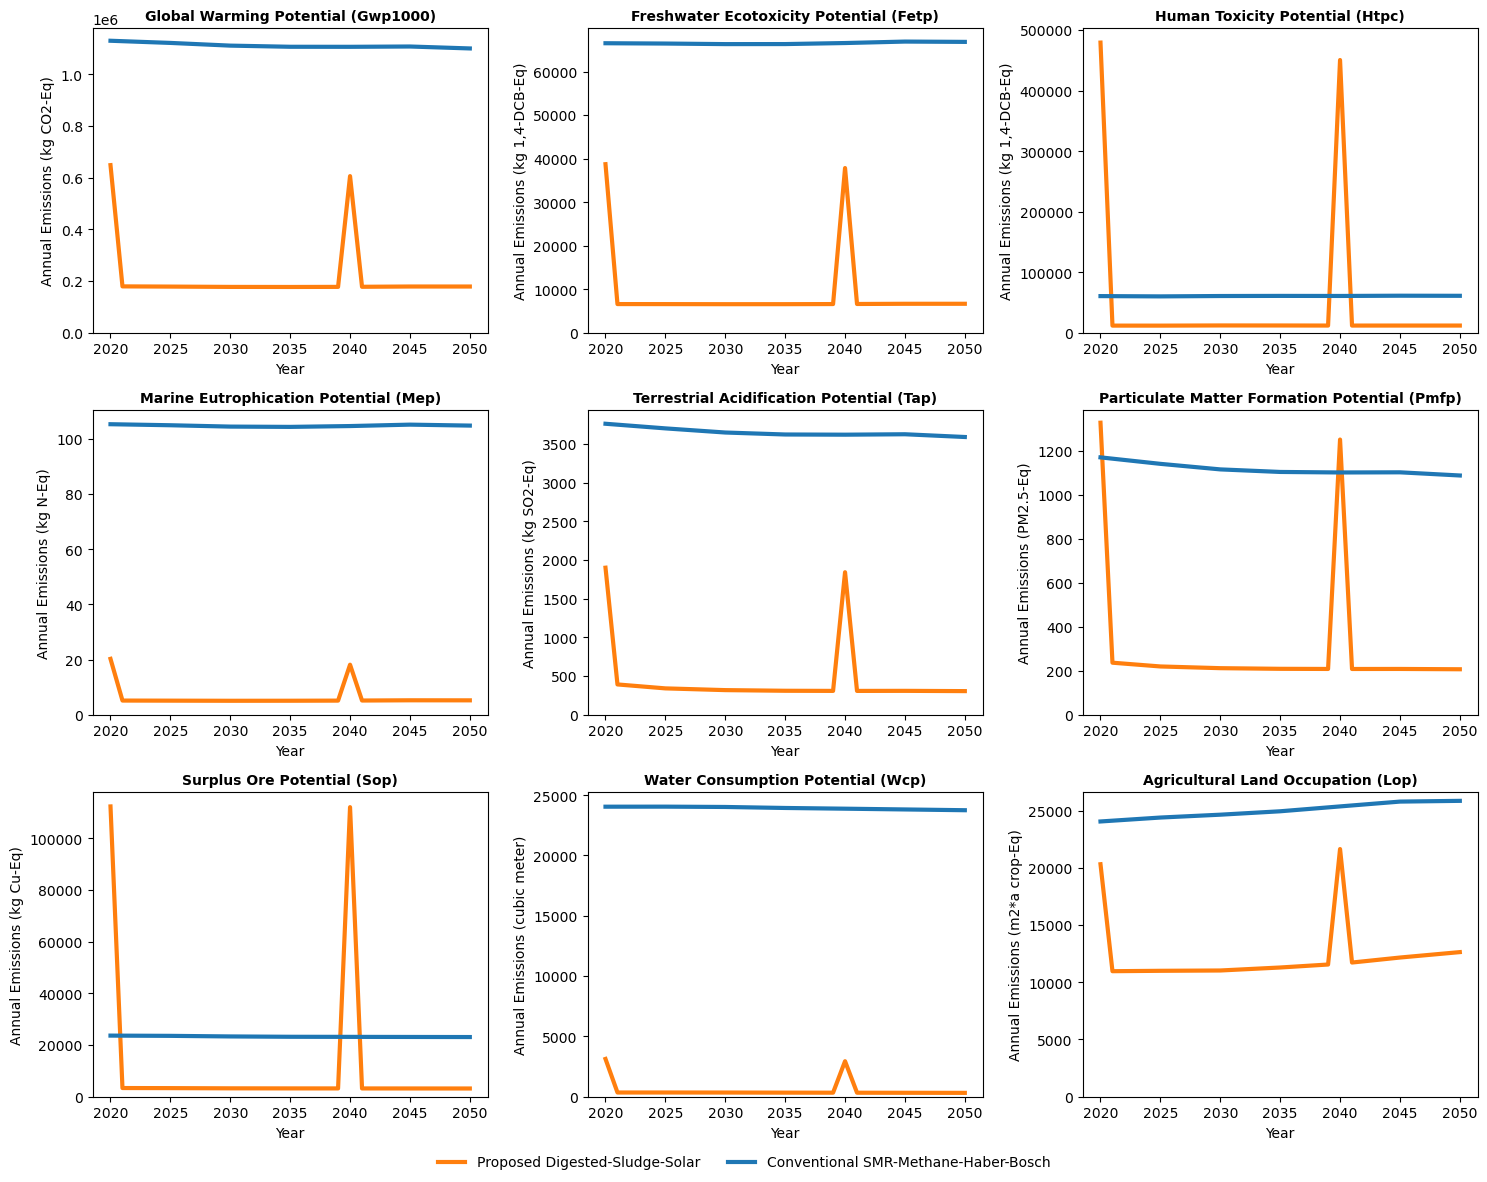

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    p_line, = ax.plot(years, proposed_emissions[metric], label='Proposed', linewidth=3, color='#ff7f0e')  # Orange
    c_line, = ax.plot(years, conventional_emissions[metric], label='Conventional', linewidth=3, color='#1f77b4')  # Blue
    ax.set_ylim(bottom=0)
    ax.set_title(metric, fontsize=10, weight='bold')
    ax.set_xlabel("Year")
    unit = metric_to_unit[metric]
    ax.set_ylabel(f"Annual Emissions ({unit})")

fig.legend([p_line, c_line],
           ['Proposed Digested-Sludge-Solar', 'Conventional SMR-Methane-Haber-Bosch'],
           loc='lower center',
           ncol=2,
           frameon=False,
           fontsize=10)

fig.tight_layout(rect=[0, 0.02, 1, 1]) 
plt.show()

**Difference between 2020 and 2050 annual emissions results of conventional system for PMF and LOP metrics**

In [22]:
conventional_emissions_pmf_2020 = conventional_emissions['Particulate Matter Formation Potential (Pmfp)'][0]
conventional_emissions_pmf_2050 = conventional_emissions['Particulate Matter Formation Potential (Pmfp)'][30]
difference_pmf = ((conventional_emissions_pmf_2020-conventional_emissions_pmf_2050)/conventional_emissions_pmf_2020)*100
difference_pmf

7.039222140452275

In [23]:
conventional_emissions_lop_2020 = conventional_emissions['Agricultural Land Occupation (Lop)'][0]
conventional_emissions_lop_2050 = conventional_emissions['Agricultural Land Occupation (Lop)'][30]
difference_lop = ((conventional_emissions_lop_2050-conventional_emissions_lop_2020)/conventional_emissions_lop_2020)*100
difference_lop

7.492359010408801

**Create pandas dfs to csv for quick stats from proposed and conventional total emissions per year**

In [24]:
years = list(range(2020, 2051))
proposed_emissions_df = pd.DataFrame({'Year': years})
for metric, values in proposed_emissions.items():
    proposed_emissions_df[metric] = values
#proposed_emissions_df.to_excel(r'C:\directory\proposed_emissions_df.xlsx',index=False)
proposed_emissions_df.head(3)

,Year,Global Warming Potential (Gwp1000),Freshwater Ecotoxicity Potential (Fetp),Human Toxicity Potential (Htpc),Marine Eutrophication Potential (Mep),Terrestrial Acidification Potential (Tap),Particulate Matter Formation Potential (Pmfp),Surplus Ore Potential (Sop),Water Consumption Potential (Wcp),Agricultural Land Occupation (Lop)
0,2020,648152.561611,38717.685047,479373.941718,20.255317,1900.269069,1329.161895,112399.654152,3127.913943,20312.617511
1,2021,179358.587744,6591.598335,11836.985060,5.133792,391.400207,236.810572,3342.341534,345.074405,10964.756931
2,2022,179165.397090,6589.437962,11830.137246,5.125535,378.656583,232.527257,3333.602430,345.265557,10973.284629


In [25]:
years = list(range(2020, 2051))
conventional_emissions_df = pd.DataFrame({'Year': years})
for metric, values in conventional_emissions.items():
    conventional_emissions_df[metric] = values
#conventional_emissions_df.to_excel(r'C:\directory\conventional_emissions_df.xlsx',index=False)
conventional_emissions_df.head(3)

,Year,Global Warming Potential (Gwp1000),Freshwater Ecotoxicity Potential (Fetp),Human Toxicity Potential (Htpc),Marine Eutrophication Potential (Mep),Terrestrial Acidification Potential (Tap),Particulate Matter Formation Potential (Pmfp),Surplus Ore Potential (Sop),Water Consumption Potential (Wcp),Agricultural Land Occupation (Lop)
0,2020,1.128995e+06,66493.178087,60577.615450,105.335459,3760.731186,1171.406707,23647.136234,24045.832203,24049.455587
1,2021,1.127322e+06,66478.769600,60486.255763,105.260787,3748.775772,1165.510281,23627.988485,24046.630368,24118.081536
2,2022,1.125649e+06,66464.361112,60394.896076,105.186115,3736.820357,1159.613856,23608.840735,24047.428533,24186.707486


**Cumulative emissions up to year**

In [26]:
# both systems
proposed_cumulative = {metric: np.cumsum(proposed_emissions[metric]) for metric in metrics}
conventional_cumulative = {metric: np.cumsum(conventional_emissions[metric]) for metric in metrics}

In [27]:
proposed_cumulative['Global Warming Potential (Gwp1000)'][0] # 0-30

648152.561611198

In [28]:
conventional_cumulative['Global Warming Potential (Gwp1000)'][0] # 0-30

1128994.641414098

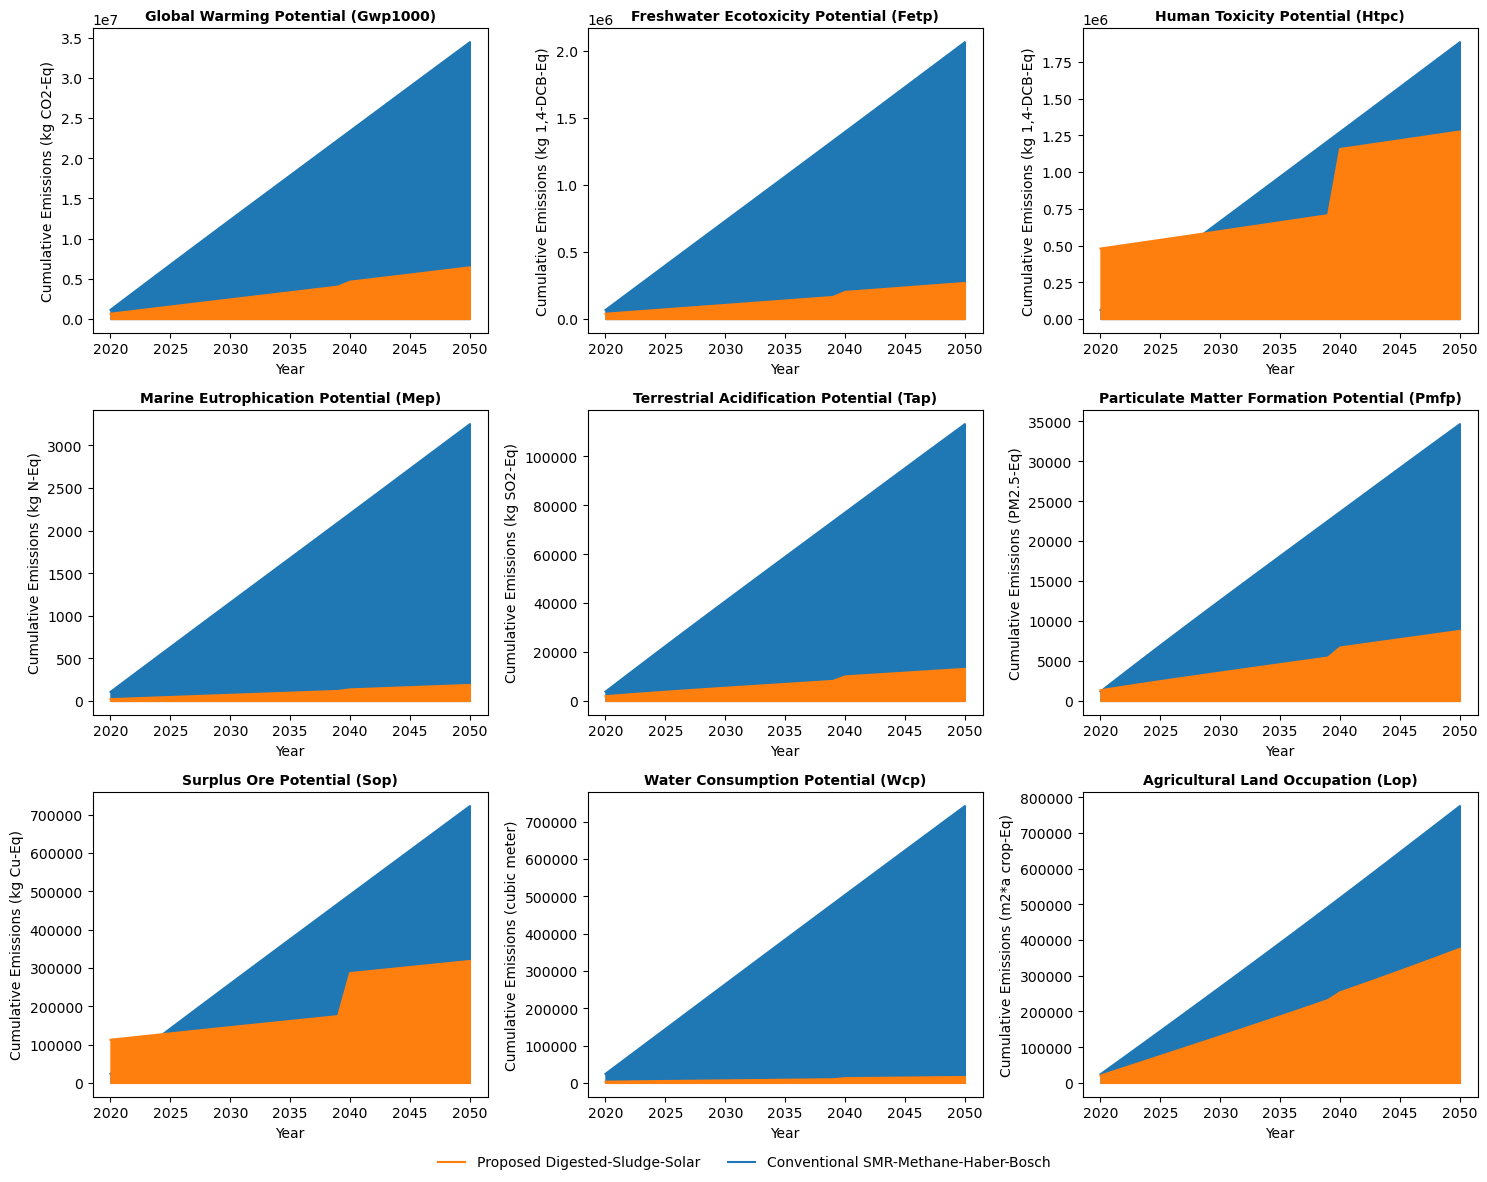

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    c_line, = ax.plot(years, conventional_cumulative[metric], label='Conventional', zorder=1)
    ax.fill_between(years, conventional_cumulative[metric], color=c_line.get_color(), zorder=1)
    p_line, = ax.plot(years, proposed_cumulative[metric], label='Proposed', zorder=2)
    ax.fill_between(years, proposed_cumulative[metric], color=p_line.get_color(), zorder=2)
    ax.set_title(metric, fontsize=10, weight='bold')
    ax.set_xlabel("Year")
    unit = metric_to_unit[metric]
    ax.set_ylabel(f"Cumulative Emissions ({unit})")

fig.legend([p_line, c_line],
           ['Proposed Digested-Sludge-Solar', 'Conventional SMR-Methane-Haber-Bosch'],
           loc='lower center',
           ncol=2,
           frameon=False,
           fontsize=10)

fig.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()

**Sensitivity analysis on total 30 year LCA results per functional unit due to change in input independent variable**

In [30]:
# this cell leverages the previous code of cells [10] (import lifecycle efs), [11] (proposed system annual emissions by process), and [15] (total annual emissions)
# while [15] depends on output of [11], [11] combines [10] and the output of calculate_time_discretized_inventory()
# calculate_time_discretized_inventory() depends on output of calculate_sludge_to_fertilizer_impacts() 
# calculate_sludge_to_fertilizer_impacts() calls the defined dependendent variables (functions) with the approriate indepedent variables specified
# calculate_sludge_to_fertilizer_impacts() brings together the outputs of different functions and does extra algebra to calculate meaningful quantities 

def run_sensitivity_analysis(baseline_variables, sensitivity_csv_path, interpolated_df_path):
    sensitivity_df = pd.read_csv(sensitivity_csv_path)
    interpolated_df = pd.read_csv(interpolated_df_path)
    
    metrics = ['Global Warming Potential (Gwp1000)', 'Freshwater Ecotoxicity Potential (Fetp)',
        'Human Toxicity Potential (Htpc)', 'Marine Eutrophication Potential (Mep)',
        'Terrestrial Acidification Potential (Tap)', 'Particulate Matter Formation Potential (Pmfp)',
        'Surplus Ore Potential (Sop)', 'Water Consumption Potential (Wcp)',
        'Agricultural Land Occupation (Lop)']
    
    unit_df = interpolated_df[interpolated_df['lcia'].isin(metrics)][['lcia', 'lcia_unit']].drop_duplicates()
    metric_to_unit = dict(zip(unit_df['lcia'], unit_df['lcia_unit']))
    
    diesel_density = 0.832
    years = range(2020, 2051)
    
    process_map = {
        'loading_energy': 'diesel production, petroleum refinery operation',
        'transport': 'transport, freight, lorry, diesel, 40t gross weight, EURO-VI, long haul',
        'csp_carbon_steel_kg': 'steel production, converter, unalloyed',
        'csp_stainless_steel_kg': 'steel production, electric, chromium steel 18/8',
        'csp_glass_kg': 'solar glass production, low-iron',
        'glass_recycled_kg': 'solar glass manufacturing from cullet'
    }
    
    sensitivity_results = {}
    
    # Create median baseline
    median_variables = copy.deepcopy(baseline_variables)
    for _, row in sensitivity_df.iterrows():
        variable_name = row['Variable']
        median_value = row['Median']
        if variable_name in median_variables:
            median_variables[variable_name] = median_value
    
    # Run baseline case
    baseline_results = calculate_lca_for_scenario(median_variables, interpolated_df, metrics, 
                                                metric_to_unit, diesel_density, years, process_map)
    sensitivity_results['baseline'] = baseline_results
    
    # Run sensitivity analysis
    for _, row in sensitivity_df.iterrows():
        variable_name = row['Variable']
        min_value = row['Min']
        max_value = row['Max']
        
        if variable_name not in baseline_variables:
            continue
        
        # Min case
        min_variables = copy.deepcopy(median_variables)
        min_variables[variable_name] = min_value
        min_results = calculate_lca_for_scenario(min_variables, interpolated_df, metrics,
                                               metric_to_unit, diesel_density, years, process_map)
        sensitivity_results[f"{variable_name}_min"] = min_results
        
        # Max case
        max_variables = copy.deepcopy(median_variables)
        max_variables[variable_name] = max_value
        max_results = calculate_lca_for_scenario(max_variables, interpolated_df, metrics,
                                               metric_to_unit, diesel_density, years, process_map)
        sensitivity_results[f"{variable_name}_max"] = max_results
    
    return sensitivity_results

def calculate_lca_for_scenario(variables, interpolated_df, metrics, metric_to_unit, diesel_density, years, process_map):
    yearly_inventory, csp_manufacturing_years, glass_recycling_years = calculate_time_discretized_inventory(variables)
    
    proposed_results = {metric: {'unit': metric_to_unit[metric]} for metric in metrics}
    
    for year in years:
        inventory = yearly_inventory[year]
        
        ef = interpolated_df[
            (interpolated_df['actual_year'] == year) &
            (interpolated_df['scenario'] == 'SSP2-Base') &
            (interpolated_df['method'] == 'RECIPE') &
            (interpolated_df['lcia'].isin(metrics)) &
            (interpolated_df['process'].isin(process_map.values()))
        ].pivot(index='process', columns='lcia', values='value')
        
        wet_sludge_tkm = (inventory['wet_sludge_processed_kg'] / 1000) * variables['distance_WWTP_to_drying']
        dried_sludge_tkm = (inventory['dried_sludge_produced_kg'] / 1000) * variables['distance_drying_to_farm']
        glass_tkm = (inventory['glass_recycled_kg'] / 1000) * variables['glass_transport_distance']
        transport_tkm = wet_sludge_tkm + dried_sludge_tkm + glass_tkm
        
        quantities = {
            'loading_energy': inventory['loading_energy'] * diesel_density,
            'transport': transport_tkm,
            'csp_carbon_steel_kg': inventory['csp_carbon_steel_kg'],
            'csp_stainless_steel_kg': inventory['csp_stainless_steel_kg'],
            'csp_glass_kg': inventory['csp_glass_kg'],
            'glass_recycled_kg': inventory['glass_recycled_kg']
        }
        
        for metric in metrics:
            proposed_results[metric][year] = {}
            for key, qty in quantities.items():
                process = process_map[key]
                emission_factor = ef.loc[process, metric]
                emissions = qty * emission_factor
                proposed_results[metric][year][key] = {
                    'quantity': qty,
                    'emissions': emissions
                }
    
    proposed_emissions = {metric: [] for metric in metrics}
    for metric in metrics:
        for year in years:
            total_proposed_emissions = sum(process['emissions'] for process in proposed_results[metric][year].values())
            proposed_emissions[metric].append(total_proposed_emissions)
    
    return {
        'detailed_results': proposed_results,
        'annual_emissions': proposed_emissions,
        'yearly_inventory': yearly_inventory,
        'csp_manufacturing_years': csp_manufacturing_years,
        'glass_recycling_years': glass_recycling_years
    }

def run_analysis():
    baseline_variables = independent_variables
    sensitivity_csv_path = r'C:\directory\independent_variable_sensitivity.csv'
    interpolated_df_path = r"C:\directory\liaison_results_lifecycle_EFs_interpolated_annual.csv"
    sensitivity_results = run_sensitivity_analysis(baseline_variables, sensitivity_csv_path, interpolated_df_path)
    return sensitivity_results

In [31]:
sensitivity_results = run_analysis()
# sensitivity_results[scenario][result_type][metric_or_year][year_or_flow][process_or_value]

# scenarios = 'baseline' and the following: 
#  'initial_nitrogen_content_min','initial_nitrogen_content_max',
# 'initial_moisture_content_min','initial_moisture_content_max',
# 'total_solids_content_min','total_solids_content_max',
# 'volatile_solids_fraction_min','volatile_solids_fraction_max',
# 'nitrogen_retention_fraction_min','nitrogen_retention_fraction_max',
# 'organic_degradation_fraction_min','organic_degradation_fraction_max',
# 'nitrogen_loss_drying_fraction_min','nitrogen_loss_drying_fraction_max',
# 'distance_WWTP_to_drying_min','distance_WWTP_to_drying_max',
# 'distance_drying_to_farm_min','distance_drying_to_farm_max',
# 'transport_nitrogen_loss_fraction_min','transport_nitrogen_loss_fraction_max',
# 'truck_carrying_capacity_min','truck_carrying_capacity_max',
# 'glass_recycling_ratio_min','glass_recycling_ratio_max',
# 'glass_transport_distance_min','glass_transport_distance_max',
# 'plant_available_nitrogen_fraction_min','plant_available_nitrogen_fraction_max',
# 'target_moisture_content_min','target_moisture_content_max',
# 'facility_capacity_min','facility_capacity_max',
# 'solar_capacity_factor_min','solar_capacity_factor_max',
# 'csp_module_thermal_capacity_min','csp_module_thermal_capacity_max',
# 'latent_heat_vaporization_min','latent_heat_vaporization_max',
# 'diesel_transport_consumption_per_km_ton_min','diesel_transport_consumption_per_km_ton_max',
# 'diesel_loading_energy_consumption_per_ton_min','diesel_loading_energy_consumption_per_ton_max']

# result_type = ['detailed_results','annual_emissions','yearly_inventory','csp_manufacturing_years','glass_recycling_years']
# detailed results are broken by metric where each metric has the yearly results from 2020-2050 dissagregated by process
# annual_emissions are broken by metric where each metric has the yearly results from 2020-2050

In [32]:
sensitivity_results['diesel_loading_energy_consumption_per_ton_max']['detailed_results']['Global Warming Potential (Gwp1000)'][2020]

{'loading_energy': {'quantity': 17541.333333333332,
  'emissions': 14766.26713793398},
 'transport': {'quantity': 1506935.0833333333,
  'emissions': 169707.60030665842},
 'csp_carbon_steel_kg': {'quantity': 116124, 'emissions': 203103.0971958689},
 'csp_stainless_steel_kg': {'quantity': 42504, 'emissions': 220899.798162241},
 'csp_glass_kg': {'quantity': 40563, 'emissions': 44597.887854473614},
 'glass_recycled_kg': {'quantity': 0, 'emissions': 0.0}}

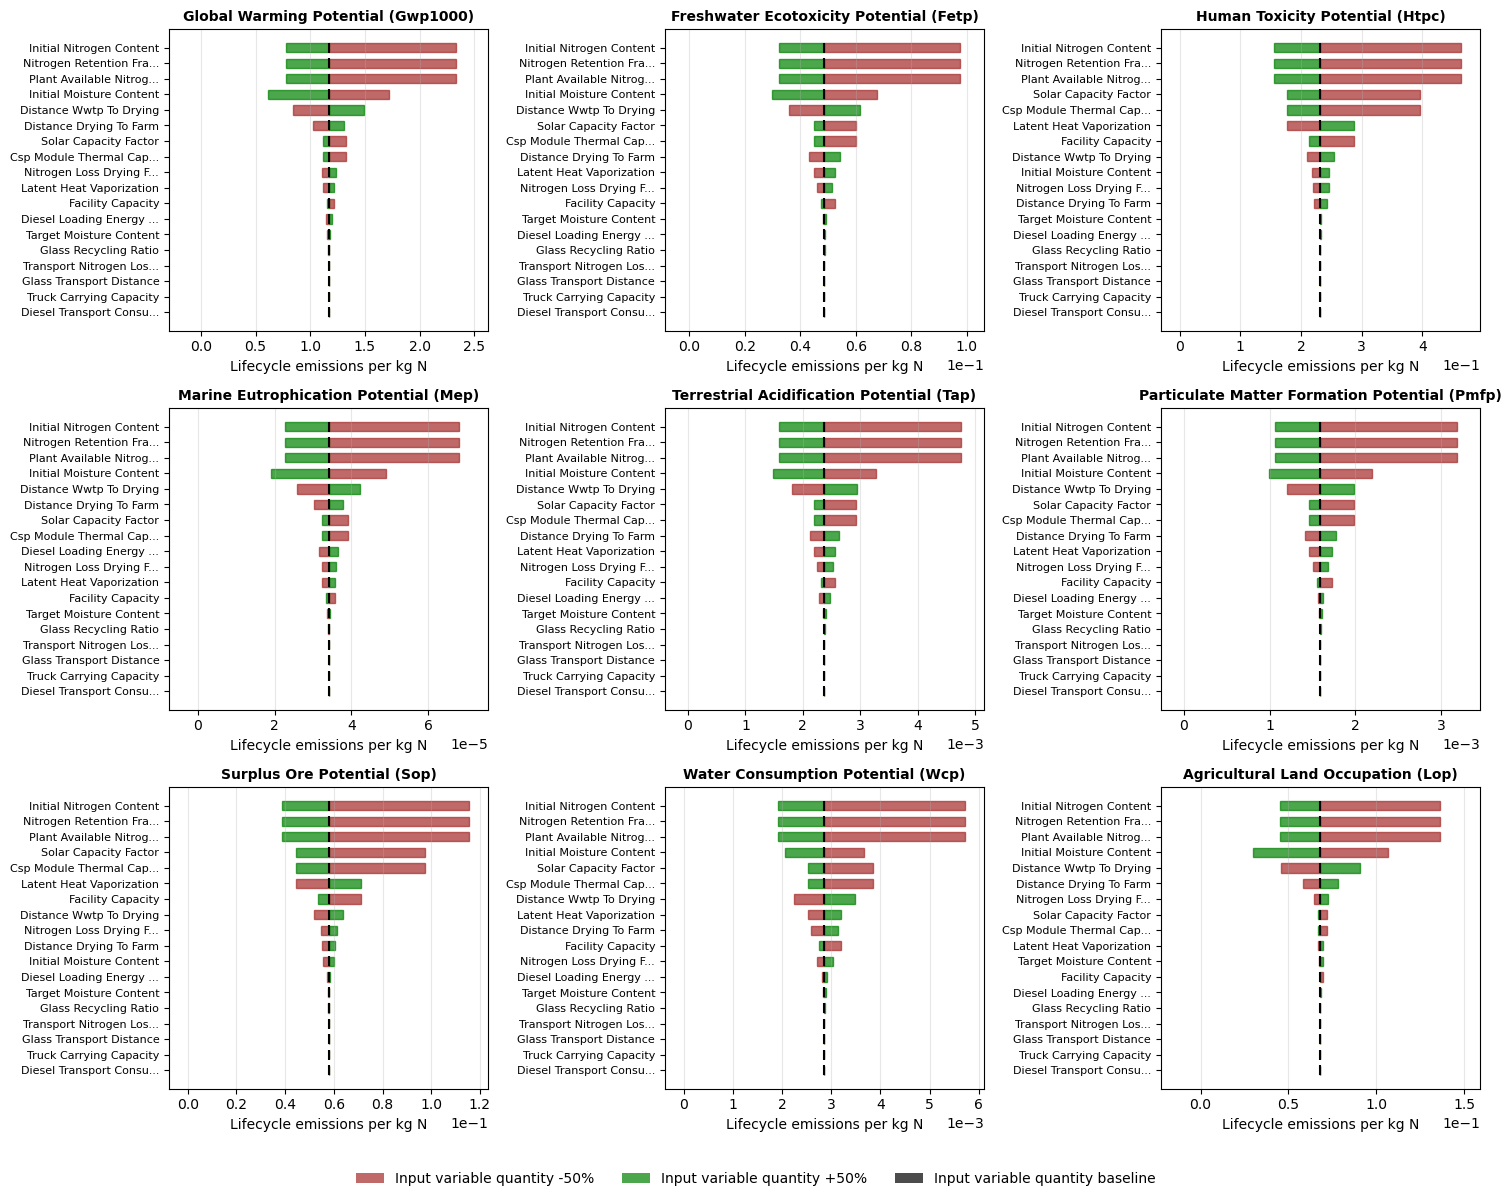

In [35]:
variables = []
for scenario in sensitivity_results.keys():
   if scenario != 'baseline' and scenario.endswith('_min'):
       var_name = scenario[:-4]  # Remove '_min'
       variables.append(var_name)

variables_to_exclude = ['volatile_solids_fraction', 'organic_degradation_fraction', 'total_solids_content']
variables = [var for var in variables if var not in variables_to_exclude]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

min_max_emissions_dict = {}
for metric_idx, metric in enumerate(metrics):
   ax = axes[metric_idx]
   
   plot_data = []
   y_positions = []
   variable_labels = []
   
   for var_idx, variable in enumerate(variables):
       min_scenario = f"{variable}_min"
       max_scenario = f"{variable}_max"
       
       if min_scenario in sensitivity_results and max_scenario in sensitivity_results:
           baseline_emissions = sum(sensitivity_results['baseline']['annual_emissions'][metric])
           min_emissions = sum(sensitivity_results[min_scenario]['annual_emissions'][metric])
           max_emissions = sum(sensitivity_results[max_scenario]['annual_emissions'][metric])

           baseline_nitrogen = sum(sensitivity_results['baseline']['yearly_inventory'][year]['nitrogen_delivered_kg'] for year in range(2020, 2051))
           min_nitrogen = sum(sensitivity_results[min_scenario]['yearly_inventory'][year]['nitrogen_delivered_kg'] for year in range(2020, 2051))
           max_nitrogen = sum(sensitivity_results[max_scenario]['yearly_inventory'][year]['nitrogen_delivered_kg'] for year in range(2020, 2051))
            
           baseline_emissions = baseline_emissions / baseline_nitrogen
           min_emissions = min_emissions / min_nitrogen
           max_emissions = max_emissions / max_nitrogen
           
           emissions_range = [min_emissions, baseline_emissions, max_emissions]
           plot_data.append(emissions_range)
           y_positions.append(var_idx)

           if metric not in min_max_emissions_dict:
               min_max_emissions_dict[metric] = {}
           min_max_emissions_dict[metric][variable] = {'min_emissions':min_emissions,
                                                       'base_emissions':baseline_emissions,
                                                       'max_emissions':max_emissions}
           
           clean_var_name = variable.replace('_', ' ').title()
           if len(clean_var_name) > 25:  # Truncate long names
               clean_var_name = clean_var_name[:22] + '...'
           variable_labels.append(clean_var_name)
   
   plot_data_with_widths = []
   for i, (emissions_range, y_pos) in enumerate(zip(plot_data, y_positions)):
       min_val, baseline_val, max_val = emissions_range 
       bar_width = max(emissions_range) - min(emissions_range)
       plot_data_with_widths.append((bar_width, emissions_range, variable_labels[i]))
   
   plot_data_with_widths.sort(key=lambda x: x[0], reverse=True)
   
   for i, (bar_width, emissions_range, var_label) in enumerate(plot_data_with_widths):
       min_val, baseline_val, max_val = emissions_range 
       y_pos = i  # Use sorted position
       bar_height = 0.6
       
       if min_val < max_val:  # Variable decrease → emission decrease, Variable increase → emission increase
           # Red segment: from min_val to baseline_val (left side)
           red_rect = Rectangle((min_val, y_pos - bar_height/2), baseline_val - min_val, bar_height,
                               facecolor='brown', edgecolor='brown', alpha=0.7)
           ax.add_patch(red_rect)
           # Green segment: from baseline_val to max_val (right side)
           green_rect = Rectangle((baseline_val, y_pos - bar_height/2), max_val - baseline_val, bar_height,
                                 facecolor='green', edgecolor='green', alpha=0.7)
           ax.add_patch(green_rect)
       else:                  # if min_val > max_val: Variable decrease → emission increase, Variable increase → emission decrease
           # Red segment: from baseline_val to min_val (right side)
           red_rect = Rectangle((baseline_val, y_pos - bar_height/2), min_val - baseline_val, bar_height,
                               facecolor='brown', edgecolor='brown', alpha=0.7)
           ax.add_patch(red_rect)
           # Green segment: from max_val to baseline_val (left side)
           green_rect = Rectangle((max_val, y_pos - bar_height/2), baseline_val - max_val, bar_height,
                                 facecolor='green', edgecolor='green', alpha=0.7)
           ax.add_patch(green_rect)
           
       ax.scatter(baseline_val, y_pos, color='black', s=50, zorder=3, marker='|')
   
   sorted_labels = [item[2] for item in plot_data_with_widths]
   sorted_y_positions = list(range(len(sorted_labels)))
       
   sorted_labels = [item[2] for item in plot_data_with_widths]
   sorted_y_positions = list(range(len(sorted_labels)))
   ax.set_yticks(sorted_y_positions)
   ax.set_yticklabels(sorted_labels, fontsize=8)
   ax.set_xlabel('Lifecycle emissions per kg N')
   ax.set_title(f'{metric}', fontsize=10, fontweight='bold')
   ax.grid(True, axis='x', alpha=0.3)
   ax.invert_yaxis()  

   if plot_data:
       baseline_values = [data[1] for data in plot_data]
       center = np.mean(baseline_values)
       all_values = [val for data in plot_data for val in data]
       data_range = max(all_values) - min(all_values)
       margin = data_range * 0.35
       ax.set_xlim(center - data_range/2 - margin, center + data_range/2 + margin) 
    
   ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
   
plt.tight_layout()

legend_elements = [Rectangle((0, 0), 1, 1, facecolor='brown', alpha=0.7, label='Input variable quantity -50%'),
                   Rectangle((0, 0), 1, 1, facecolor='green', alpha=0.7, label='Input variable quantity +50%'),
                   Rectangle((0, 0), 1, 1, facecolor='black', alpha=0.7, label='Input variable quantity baseline')]

fig.legend(handles=legend_elements, 
           loc='lower center', 
           ncol=3, 
           frameon=False, 
           fontsize=10)

plt.tight_layout(rect=[0, 0.04, 1, 1]) 
plt.show()

**Create pandas df to csv for quick stats from proposed sensitivity lifecycle emissions per kg N**

In [30]:
rows = []
for metric, variables in min_max_emissions_dict.items():
    for variable, emissions in variables.items():
        rows.append({
            'metric': metric,
            'variable': variable,
            'min_emissions': emissions['min_emissions'],
            'base_emissions': emissions['base_emissions'],
            'max_emissions': emissions['max_emissions']
        })
df_sensitivity_emissions = pd.DataFrame(rows)
#df_sensitivity_emissions.to_excel(r'C:\directory\sensitivity_lca_emissions_per_kg_N_metric_variable_df.xlsx',index=False)
df_sensitivity_emissions

,metric,variable,min_emissions,base_emissions,max_emissions
0,Global Warming Potential (Gwp1000),initial_nitrogen_content,2.333914,1.166957,0.777971
1,Global Warming Potential (Gwp1000),initial_moisture_content,1.716601,1.166957,0.617313
2,Global Warming Potential (Gwp1000),total_solids_content,1.166957,1.166957,1.166957
3,Global Warming Potential (Gwp1000),volatile_solids_fraction,1.166957,1.166957,1.166957
4,Global Warming Potential (Gwp1000),nitrogen_retention_fraction,2.333914,1.166957,0.777971
...,...,...,...,...,...
184,Agricultural Land Occupation (Lop),solar_capacity_factor,0.071801,0.068277,0.067103
185,Agricultural Land Occupation (Lop),csp_module_thermal_capacity,0.071801,0.068277,0.067103
186,Agricultural Land Occupation (Lop),latent_heat_vaporization,0.067103,0.068277,0.069452
187,Agricultural Land Occupation (Lop),diesel_transport_consumption_per_km_ton,0.068277,0.068277,0.068277
